# Diabetes Readmission Project

Tongfei Wang
(tw2740)

APANPS5335 Machine Learning

Columbia University

12/10/2020

# 1. Introduction

Current dataset contains diabetes patients' clinical data from 1999 to 2008 in 130 US hospitals. The project aims to predict whether or not a diabetes patient will be readmitted to the hospital given various medical data such as medications administered, laboratory tests, and patient attributes. The project eventually will build a machine learning model to predict diabetes patients' readmission. With the ensemble model, hospitals can predict whether a new diabetes patient will be readmitted or not. Readmission rate is usually seen as an indicator of quality of care for hospitals. The lower readmission rate, the hospital will be rated with higher quality of care. Thus, with a robust machine learning model to predict patients' readmission, the hospital can take corresponding actions to reduce the readmission rate and further reduce costs for the care of individuals with diabetes. In addition. the hospital will also understand what factors are more important in predicting readmission and then take precautions accordingly.

# 2. Exploratory Analysis

## 1) Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

##  2) Read Data

In [2]:
df = pd.read_csv('/Users/Demi/Downloads/Machine Learning/Final Project/Data/diabetic_data.csv')
df.replace('?',np.nan,inplace=True)

## 3) Missing Values

<BarContainer object of 50 artists>

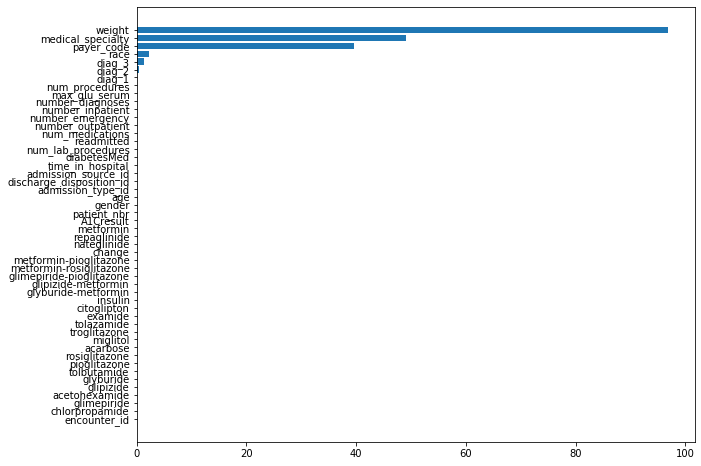

In [3]:
plt.figure(figsize=(10,8))
missing_values = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing_values.sort_values('na_percent',inplace=True)
plt.barh(missing_values['column'],width=missing_values['na_percent'])

According to the chart above, only several columns contain over 40% of missing values, including weight, medical_specialty, and payer_code. These columns need to be removed from analysis later

## 4) Feature Visualizations

Text(0.5, 1.0, 'Distribution of Readmission')

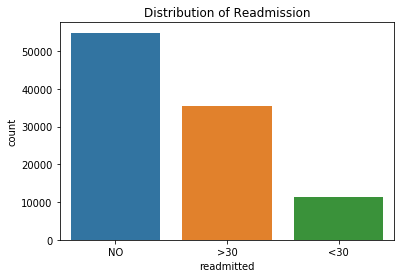

In [4]:
sns.countplot(df['readmitted']).set_title('Distribution of Readmission')

The variable "readmitted" has three levels: no, >30, and <30. Since only very few patients' in the <30 category, it will be an highly unbalanced dataset to build model on. 

Thus, I will merge >30 and <30 to as one category, Yes.   

Text(0.5, 1.0, 'Age V.S. Readmission')

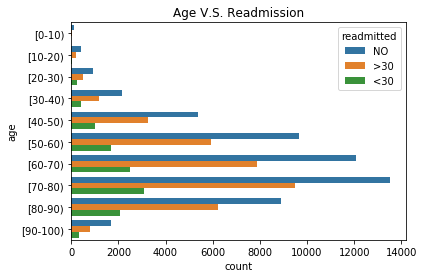

In [5]:
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age V.S. Readmission')

Feature "age" overall follows a normal distribution.

Text(0.5, 1.0, 'Number of medication used V.S. Readmission')

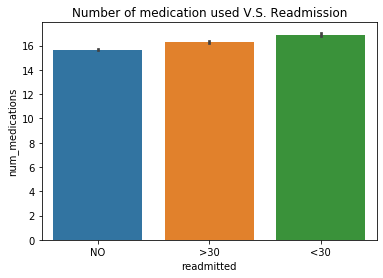

In [6]:
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used V.S. Readmission")

Number of medications seems slighly higher for patients who get readmitted than patients who were not.

Text(0.5, 1.0, 'Time in hospital V.S. Readmission')

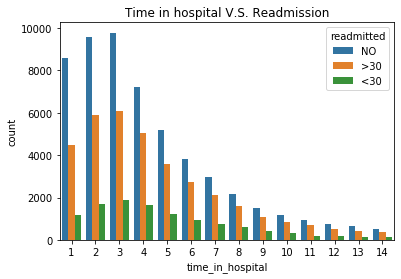

In [7]:
sns.countplot(df['time_in_hospital'], hue = df['readmitted']).set_title("Time in hospital V.S. Readmission")

Non-readmitted patients spend significantly higher time in the hospital than readmitted patients. 'time_in_hospital' should be a very strong predictor of whether a patient will be readmitted or not.

Text(0.5, 1.0, 'Change of Medication V.S. Readmission')

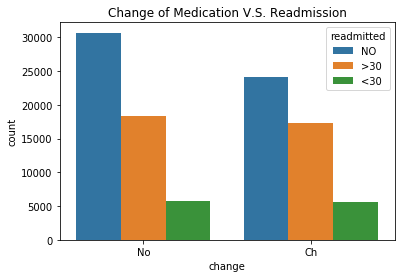

In [8]:
sns.countplot(df['change'], hue = df['readmitted']).set_title('Change of Medication V.S. Readmission')

Text(0.5, 1.0, 'Diabetes Medication V.S. Readmission')

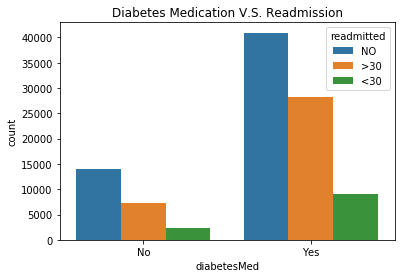

In [9]:
sns.countplot(df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication V.S. Readmission')

Text(0.5, 1.0, 'Diabetes Medication V.S. Readmission')

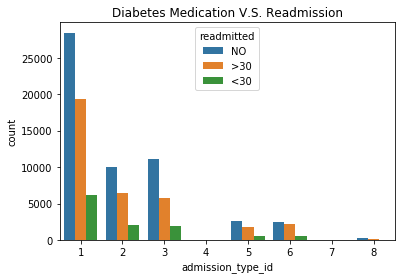

In [10]:
sns.countplot(df['admission_type_id'], hue = df['readmitted']).set_title('Diabetes Medication V.S. Readmission')

Text(0.5, 1.0, 'Diabetes Medication V.S. Readmission')

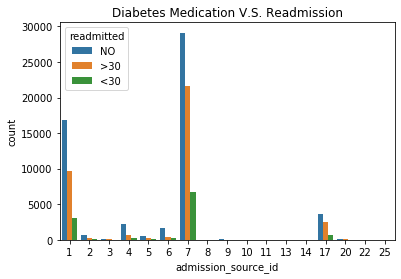

In [11]:
sns.countplot(df['admission_source_id'], hue = df['readmitted']).set_title('Diabetes Medication V.S. Readmission')

admission_type_id and admission_source_id has too many categories and I will merge some categories to one in the later section.

# 3. Data Cleaning & Feature Engineering

## 1) Dropping NA & Irrelevant Features

In [12]:
# Dropping columns with over 40% NAs
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)
# Dropping columns with one level
df = df.drop(['citoglipton', 'examide'], axis = 1)
# Dropping irrelevant ID columns
df.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)
# Dropping unknown/invalid rows in gender
df=df[df['gender']!='Unknown/Invalid']
# Dropping rows with NAs
df.dropna(inplace=True)

## 2) Feature Enginnering

### i. Diag Columns Regroup
Three diag columns (Diag_1, Diag_2, Diag_3) are originally numbers that were coded as first three digits of ICD9. Therefore, I collapsed these diagnosis codes into 9 disease categories, Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. 

According to:https://www.kaggle.com/iabhishekofficial/prediction-on-hospital-readmission

In [13]:
# Diag_1, Diag_2, Diag_3 reshape
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df[col] = df[col].str.replace('E','-')
    df[col] = df[col].str.replace('V','-')
    condition = df[col].str.contains('250')
    df.loc[condition,col] = '250'
df[diag_cols] = df[diag_cols].astype(float)

In [14]:
# Regrouping Diag_1, Diag_2, Diag_3
for col in diag_cols:
    
    df['temp']= np.nan
    
    con = df[col]==250
    df.loc[con,'temp']='Diabetes'
    
    con = (df[col]>=390) & (df[col]<=458) | (df[col]==785)
    df.loc[con,'temp']='Circulatory'
    
    con = (df[col]>=460) & (df[col]<=519) | (df[col]==786)
    df.loc[con,'temp']='Respiratory'
    
    con = (df[col]>=520) & (df[col]<=579) | (df[col]==787)
    df.loc[con,'temp']='Digestive'
    
    con = (df[col]>=580) & (df[col]<=629) | (df[col]==788)
    df.loc[con,'temp']='Genitourinary'
    
    con = (df[col]>=800) & (df[col]<=999)
    df.loc[con,'temp']='Injury'
    
    con = (df[col]>=710) & (df[col]<=739)
    df.loc[con,'temp']='Muscoloskeletal'
    
    con = (df[col]>=140) & (df[col]<=239)
    df.loc[con,'temp']='Neoplasms'
    
    con = df[col]==0
    df.loc[con,col]='?'
    df['temp']=df['temp'].fillna('Others')
    
    con = df['temp']=='0'
    df.loc[con,'temp']=np.nan
    df[col]=df['temp']
    
    df.drop('temp',axis=1,inplace=True)

### ii. ID Related Columns Regroup
According to the charts below, admission_type_id, discharge_disposition_id, and admission_source_id have way too many categories that should be collapsed.

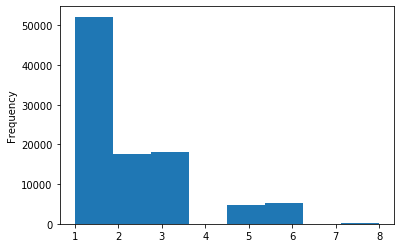

In [15]:
df.admission_type_id.plot.hist(bins = 8)

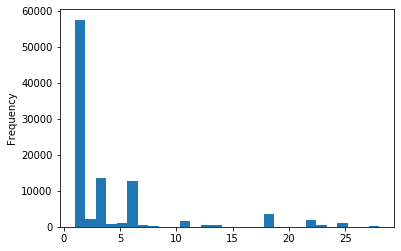

In [16]:
df.discharge_disposition_id.plot.hist(bins=29)

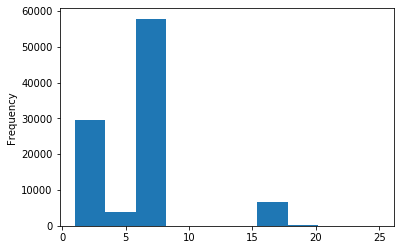

In [17]:
df.admission_source_id.plot.hist()

In [18]:
# re-encoding 'admission_type_id', 'discharge_disposition_id', 'admission_source_id' into fewer categories

#admission_type_id
df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(4,3)
df['admission_type_id'] = df['admission_type_id'].replace(7,3)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

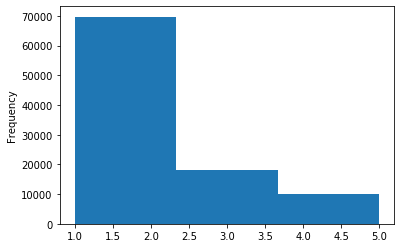

In [19]:
df.admission_type_id.plot.hist(bins = 3)

In [20]:
#discharge_disposition_id
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(10,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(29,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(30,2)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,26)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(18,26)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(7,26)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,11)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,11)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(19,11)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(20,11)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(21,11)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,12)

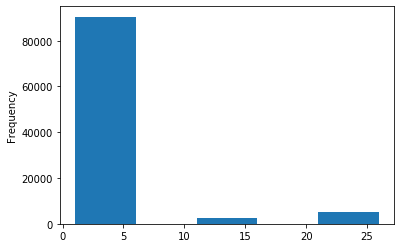

In [21]:
df.discharge_disposition_id.plot.hist(bins = 5)

In [22]:
#admission_source_id
df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)
df['admission_source_id'] = df['admission_source_id'].replace(7,1)
df['admission_source_id'] = df['admission_source_id'].replace(19,1)

df['admission_source_id'] = df['admission_source_id'].replace(5,4)
df['admission_source_id'] = df['admission_source_id'].replace(6,4)
df['admission_source_id'] = df['admission_source_id'].replace(10,4)
df['admission_source_id'] = df['admission_source_id'].replace(18,4)
df['admission_source_id'] = df['admission_source_id'].replace(22,4)
df['admission_source_id'] = df['admission_source_id'].replace(25,4)
df['admission_source_id'] = df['admission_source_id'].replace(26,4)

df['admission_source_id'] = df['admission_source_id'].replace(8,9)
df['admission_source_id'] = df['admission_source_id'].replace(15,9)
df['admission_source_id'] = df['admission_source_id'].replace(17,9)
df['admission_source_id'] = df['admission_source_id'].replace(20,9)
df['admission_source_id'] = df['admission_source_id'].replace(21,9)

df['admission_source_id'] = df['admission_source_id'].replace(12,11)
df['admission_source_id'] = df['admission_source_id'].replace(13,11)
df['admission_source_id'] = df['admission_source_id'].replace(14,11)
df['admission_source_id'] = df['admission_source_id'].replace(23,11)
df['admission_source_id'] = df['admission_source_id'].replace(24,11)


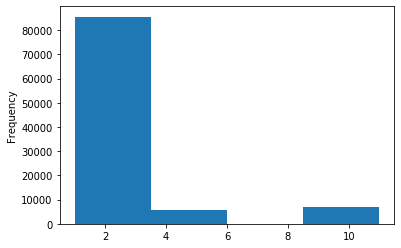

In [23]:
df.admission_source_id.plot.hist(bins = 4)

In [24]:
i = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[i] = df[i].astype('object')

### iii. Other Features' Imputation
--- 
String columns that need to be imputed to integer respectively for modelling, including age, max_glu_serum, A1Cresult, number_diagnoses, change, diabetesMed

In [25]:
# age
df['age'] = df['age'].str[1:].str.split('-',expand=True)[0]
df['age'] = df['age'].astype(int)

In [26]:
# max_glu_serum
max_glu_serum_dict = {'None':0,'Norm':100, '>200':200, '>300':300}
df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_dict)

In [27]:
# A1Cresult
A1Cresult_dict = {'None':0,
                  'Norm':5,
                  '>7':7,
                  '>8':8
                 }
df['A1Cresult'] = df['A1Cresult'].replace(A1Cresult_dict)

In [28]:
# number_diagnoses
df['number_diagnoses'] = df['number_diagnoses'].astype(int)

In [29]:
# change
change_dict = {'No':-1,
               'Ch':1
              }
df['change'] = df['change'].replace(change_dict)

In [30]:
# diabetesMed
diabetesMed_dict = {'No':-1,
                    'Yes':1
                   }
df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_dict)

---
Columns with same levels of responses ('No', 'Steady', 'Up', 'Down') can be imputed as numberics together, including the following columns.

In [31]:
df.metformin.unique()

array(['No', 'Steady', 'Up', 'Down'], dtype=object)

In [32]:
# other columns
others_dict = {'Up':10,
               'Down':-10,
               'Steady':0,
               'No':-20
              }

others_cols = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
               'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
               'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
               'insulin','glyburide-metformin','glipizide-metformin',
               'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

for col in others_cols:
    df[col] = df[col].replace(others_dict)

### iv. Readmitted
Readmitted column has three levels as described above and will be collapsed to two levels

In [33]:
# readmitted (Y)
condition = df['readmitted']!='NO'
df['readmitted'] = np.where(condition,1,0)

df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,10,1,1,1,3,59,0,18,...,-20,10,-20,-20,-20,-20,-20,1,1,1
2,AfricanAmerican,Female,20,1,1,1,2,11,5,13,...,-20,-20,-20,-20,-20,-20,-20,-1,1,0
3,Caucasian,Male,30,1,1,1,2,44,1,16,...,-20,10,-20,-20,-20,-20,-20,1,1,0
4,Caucasian,Male,40,1,1,1,1,51,0,8,...,-20,0,-20,-20,-20,-20,-20,1,1,0
5,Caucasian,Male,50,1,1,1,3,31,6,16,...,-20,0,-20,-20,-20,-20,-20,-1,1,1


### v. Get Dummy Variables

In [34]:
categorical_cols = df.select_dtypes('object').columns

for i in categorical_cols:
    df = pd.concat([df.drop(i, axis=1), pd.get_dummies(df[i],prefix = i)], axis=1)
    
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Genitourinary,diag_3_Injury,diag_3_Muscoloskeletal,diag_3_Neoplasms,diag_3_Others,diag_3_Respiratory
1,10,3,59,0,18,0,0,0,9,0,...,0,0,0,0,0,0,0,0,1,0
2,20,2,11,5,13,2,0,1,6,0,...,0,0,0,0,0,0,0,0,1,0
3,30,2,44,1,16,0,0,0,7,0,...,0,1,0,0,0,0,0,0,0,0
4,40,1,51,0,8,0,0,0,5,0,...,0,0,1,0,0,0,0,0,0,0
5,50,3,31,6,16,0,0,0,9,0,...,0,0,1,0,0,0,0,0,0,0


## 3) New Features Visualizations

Text(0.5, 1.0, 'New Distribution of Readmission')

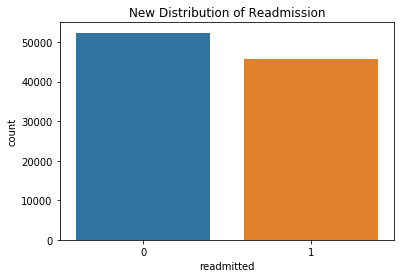

In [35]:
sns.countplot(df['readmitted']).set_title('New Distribution of Readmission')

Text(0.5, 1.0, 'Number of lab procedures V.S. Readmission')

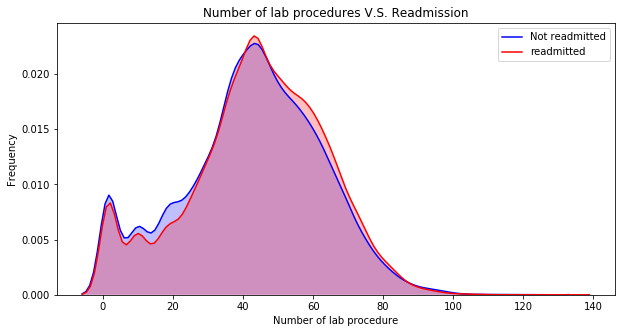

In [36]:
fig = plt.figure(figsize=(10,5),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedures V.S. Readmission')

Text(0.5, 1.0, 'A1Cresult V.S. Readmission')

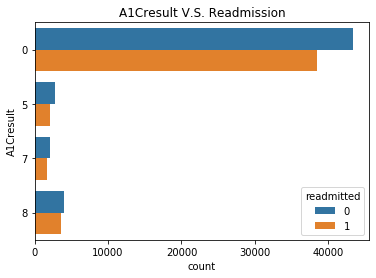

In [37]:
sns.countplot(y= df['A1Cresult'], hue = df['readmitted']).set_title('A1Cresult V.S. Readmission')

# 4. Machine Learning Models

## 1) Preparations

In [38]:
# Train Test Split
X = df.drop('readmitted',axis=1)
y = df['readmitted']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)
X_train.shape,X_test.shape

((68636, 80), (29416, 80))

In [201]:
# Define an evaluation metrics for all 5 models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

def evaluate(modelname,y,pred):
    """
    This function provides a dataframe that 
    shows the evaluation metrics 
    for any predictions and y
    """
    accuracyscore = accuracy_score(y, pred)
    precisionscore = precision_score(y, pred)
    recallscore = recall_score(y, pred)
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    scores = {'Model Name':[modelname],
              'Accuracy':[accuracyscore],
              'Precision':[precisionscore],
              'Recall': [recallscore],
              'AUC':[roc_auc]}
    df = pd.DataFrame(scores, columns = ['Model Name', 'Accuracy','Precision','Recall','AUC'])
    return(df)

## 2) Train Models & Cross Validation

## - 1 - Logistic Regression

**Description**: Logistic Regression is a model that uses a logistic function to model a binary dependent variable. The logistic regression assume that the dependent variable is binary and that the dependent variable and the independent variables are linearly dependent. The major limitation of logistic regression is this assumption of linearity between the dependent variable and independent variables. However, linearly separable data is rarely found in real-world scenarios. So usually logistic regression will not provide the best predictions. However, I choose to use logistic regression as a baseline model since the dependent variable in current analysis is a binary data.

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
# Fit Model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [63]:
# Predict on train
logpred_train = logmodel.predict(X_train)

In [154]:
# Evaluation on train
evaluate('Logistic Regression',y_train,logpred_train)

,Model Name,Accuracy,Precision,Recall,AUC
0,Logistic Regression,0.631855,0.638818,0.484283,0.622533


## - 2 - Lasso Regression

**Description**: Lasso regression is essentially a regularization process that automagically selects significant variables by shrinking the coefficients of unimportant predictors. Lasso regression allows us to model the dependent variables by optimising the binomial likelihood while imposing a lasso penalty on the parameters. Lasso regression encourages shrinking the coefficients to 0, and dropping those variates from the model. However, the limitations exist when dropping the columns might not make sense. I applied lasso regression to the current data because we ended up have over 80 variables for prediction and it might lasso regression allows feature selection and parameter shrinkage to avoid overfitting.

In [47]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [49]:
# Build original model
lassomodel = Lasso(max_iter=10000, normalize=True)

# Cross validation
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000, normalize=True)
lassocv.fit(X_train, y_train)

lassomodel.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)

# Fit model
lassomodel.fit(X_train, y_train)
print("mse = ",mean_squared_error(y_train, lassomodel.predict(X_train)))
print("best model coefficients:")
pd.Series(lassomodel.coef_, index=X.columns)

Alpha= 1.9058133174109522e-06
mse =  0.2248680452954812
best model coefficients:


age                       0.000706
time_in_hospital          0.006120
num_lab_procedures        0.000315
num_procedures           -0.009749
num_medications           0.000004
                            ...   
diag_3_Injury            -0.043090
diag_3_Muscoloskeletal   -0.015241
diag_3_Neoplasms         -0.013387
diag_3_Others            -0.018205
diag_3_Respiratory        0.005957
Length: 80, dtype: float64

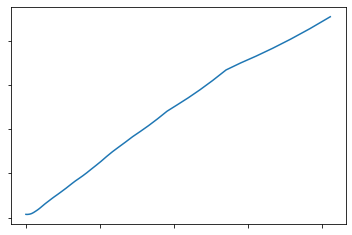

In [302]:
# CV Visualizations
a = []
for i in lassocv.mse_path_:
    a.append(i.mean())

cvresults = pd.DataFrame ({'Alpha':  lassocv.alphas_,'Mean MSE': a})
sns.lineplot(data = cvresults, x = 'Alpha',y = 'Mean MSE')


In [68]:
# Predict on train
pred_prob_train = lassomodel.predict(X_train)
lassopred_train = []
for i in pred_prob_train:
    if i >= 0.5:
        lassopred_train.append(1)
    elif i < 0.5:
        lassopred_train.append(0)

In [200]:
# Evaluation on train
evaluate('Lasso Regression',y_train,lassopred_train)

,Model Name,Accuracy,Precision,Recall,AUC
0,Lasso Regression,0.629859,0.637017,0.479315,0.620349


## - 3 - Random Forest

**Description**: Random forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees for classification. The fundamental idea is to reduce variance by combining many decision trees into a single model. However, there are still some limitations including being computationally expensive and loss of interpretation. I choose to use random forest in this project beacuse random forest is a non-parametric method and can thus handle skewed and multi-modal data as well as categorical data. It also reduces overfitting and can have a good performance on the testing data. 

In [50]:
# Build original model
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier()

In [53]:
# Cross validation
from sklearn.model_selection import RandomizedSearchCV
# Grids
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
random_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, None]}

In [60]:
# Random search of parameters
rf_cv = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=0, random_state=33)

In [61]:
# Fit CV
rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [147]:
# Print CV results
rf_cv.best_params_, rf_cv.best_score_

({'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 20},
 0.6404802144647124)

In [115]:
# View parameter tuning
rf_cv.cv_results_['mean_test_score']

array([0.63555569, 0.63723119, 0.63077685, 0.64048021, 0.6361239 ,
       0.63513317, 0.63584708, 0.63666298, 0.63724576, 0.63608019])

In [203]:
rf_cv.param_distributions

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, None]}

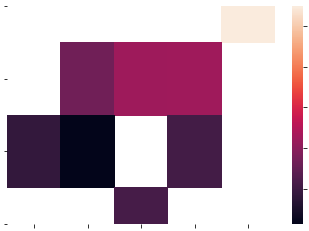

In [267]:
# Visualize parameter tuning
cvresults = pd.pivot_table(pd.DataFrame(rf_cv.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators')
ax = sns.heatmap(cvresults,annot = True )

In [208]:
# Fit model
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, max_features='auto')
rf.fit(X_train,y_train)
# Predict on train
rfpred_train = rf.predict(X_train)

In [209]:
# Evaluation on train
evaluate('Random Forest',y_train,rfpred_train)

,Model Name,Accuracy,Precision,Recall,AUC
0,Random Forest,0.893074,0.92161,0.842332,0.889868


## - 4 - XGBoost

**Description**: XGBoost is an implementation of gradient boosting machine and contains multiple boosting algorithm such as gradient boosting, multiple additive regression trees, stochastic gradient boosting or gradient boosting machines. Gradient boosting is an ensemble algorithm where the model stars from a simple tree and then new models build on the previous model by correcting the error. New models are created to predict the errors of prior models and then added together to make the final prediction. New models will be added until no further improvements can be made. However, it contains some limitations because XGBoost only works with numeric features. Current analysis applied XGBoost because it generally has great performance with low error rate and it has an built-in regularization that prevents the model from overfitting.

In [212]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Build original model
xg_train = xgb.DMatrix(X_train, label=y_train);

xgb = XGBClassifier()

# Grid
param = {
 'max_depth':range(2,6,2),
 'min_child_weight':range(1,6,2)
}


In [213]:
# Cross Validation
xgb_cv = GridSearchCV(estimator = xgb , param_grid = param, scoring='roc_auc',cv=3)

In [214]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                   

In [215]:
# Print CV results
xgb_cv.best_params_, xgb_cv.best_score_

({'max_depth': 4, 'min_child_weight': 1}, 0.6927973788705307)

In [218]:
# View parameter tuning
xgb_cv.cv_results_['params']

[{'max_depth': 2, 'min_child_weight': 1},
 {'max_depth': 2, 'min_child_weight': 3},
 {'max_depth': 2, 'min_child_weight': 5},
 {'max_depth': 4, 'min_child_weight': 1},
 {'max_depth': 4, 'min_child_weight': 3},
 {'max_depth': 4, 'min_child_weight': 5}]

In [277]:
xgb_cv.cv_results_['mean_test_score']

array([0.69024239, 0.69050311, 0.69038972, 0.69279738, 0.6926945 ,
       0.69275589])

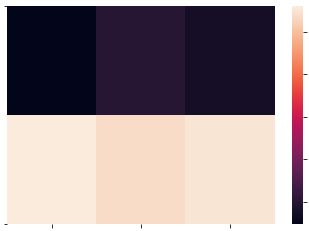

In [279]:
# Visualize parameter tuning
cvresults = pd.pivot_table(pd.DataFrame(xgb_cv.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_child_weight')
ax = sns.heatmap(cvresults,annot = True )

In [220]:
# Fit model
xgb = XGBClassifier(max_depth= 4, min_child_weight= 5)
xgb.fit(X_train, y_train)

# Predict on train
xgbpred_train =xgb.predict(X_train)

In [221]:
# Evaluation on train
evaluate('XGBoost',y_train,xgbpred_train)

,Model Name,Accuracy,Precision,Recall,AUC
0,XGBoost,0.662815,0.660276,0.570304,0.656972


## - 5 - Support Vector Machines

**Description**: A support vector machine is a supervised learning model with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other as a non-probabilistic binary linear classifier. SVM assumes an independent and identically distributed data. However, it does not perform well when the data set has more noise (i.e. target classes are overlapping). In addition, when number of features exceeds the number of training data samples, the SVM will underperform. 

In [138]:
# Build original model
from sklearn.svm import SVC 
svm = SVC()

# Grid
param = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf']}  
# Cross Validation
svm_cv = GridSearchCV(estimator = svm , param_grid = param, scoring='roc_auc',cv=3)

In [139]:
svm_cv.fit(X_train, y_train) 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [146]:
# Print CV results
svm_cv.best_params_,svm_cv.best_score_

({'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, 0.6619425534705915)

In [142]:
# View parameter tuning
svm_cv.cv_results_['params']

[{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}]

In [144]:
svm_cv.cv_results_['mean_test_score']

array([0.52539645, 0.54956362, 0.59337772, 0.64251182, 0.52546622,
       0.54953313, 0.60072784, 0.6603326 , 0.5254525 , 0.54334364,
       0.5852186 , 0.66194255, 0.5254525 , 0.54334364, 0.56837087,
       0.64451491])

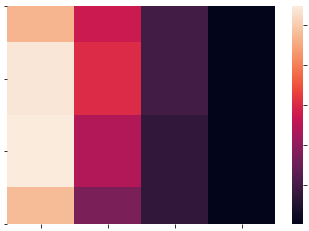

In [280]:
# Visualize parameter tuning
cvresults = pd.pivot_table(pd.DataFrame(svm_cv.cv_results_),
    values='mean_test_score', index='param_C', columns='param_gamma')
ax = sns.heatmap(cvresults,annot = True )

In [148]:
# Fit model
svm = SVC(C=10, gamma=0.001, kernel='rbf')
svm.fit(X_train, y_train)

# Predict on train
svmpred_train =svm.predict(X_train)

In [223]:
# Evaluation on train
evaluate('SVM',y_train,svmpred_train)

,Model Name,Accuracy,Precision,Recall,AUC
0,SVM,0.69092,0.713646,0.563086,0.682845


# 5. Model Evaluation & Results

In [224]:
# Logistic Regression
log_pred = logmodel.predict(X_test)
# Lasso Regression
pred_prob_test = lassomodel.predict(X_test)
lasso_pred = []
for i in pred_prob_test:
    if i >= 0.5:
        lasso_pred.append(1)
    elif i < 0.5:
        lasso_pred.append(0)
# Random Forest
rf_pred = rf.predict(X_test)
# XGBoost
xgb_pred =xgb.predict(X_test)
# SVM
svm_pred =svm.predict(X_test)

In [238]:
# Ensemble Modele
ensemble_pred = [int(a) for a in (svm_pred+xgb_pred+rf_pred+lasso_pred+log_pred)/5.0>0.5]

In [246]:
result = evaluate('Logistic Regression',y_test,log_pred).append(evaluate('Lasso Regression',y_test,lasso_pred)).append(evaluate('Random Forest',y_test,rf_pred)).append(evaluate('XGBoost',y_test,xgb_pred)).append(evaluate('SVM',y_test,svm_pred)).append(evaluate('Ensemble Model',y_test,ensemble_pred))

result.reset_index(drop = True, inplace = True)
result

,Model Name,Accuracy,Precision,Recall,AUC
0,Logistic Regression,0.627822,0.634139,0.476333,0.618205
1,Lasso Regression,0.622994,0.627816,0.469477,0.613249
2,Random Forest,0.637170,0.634687,0.522063,0.629863
3,XGBoost,0.638530,0.630269,0.543068,0.632470
4,SVM,0.621702,0.619950,0.486835,0.613141
5,Ensemble Model,0.634655,0.640421,0.492962,0.625660


# 6. Discussion & Next Steps

* Model Performances:

In this project, I have applied five machine learning models to predict whether a patient will be readmitted to the hospital or not. Among the five models, SVM has the worst performance with a 0.6131 AUC while XGBoost has the best performance with a 0.6325 AUC. XGBoost and Random Forest performed bettwe than others and the ensemble model. Ensemble methods, such as Random Forest and XGBoost, were good as they reduced variance, while providing higher stability. However, since I did not have the capacity to tune all the parameters, the limitations of my models are overfitting problem, which mostly happens with the Random Forest model. 

* Next Steps:

To further improve the performance, I will tune more parameters and apply 5 or 10 fold cross validations instead of 3 fold cross validation. In addition, I will ensemble the best 2 models instead of all 5 models for the Ensemble Model.

# 7. References

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/
https://www.kaggle.com/aldrinl/interpretable-ml-for-diabetes-patient-readmission
https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/